In [342]:
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [343]:
# Read the dataset file into a DataFrame
df = pd.read_csv('Dataset/housePrice.csv')

# Number of samples before the cleanup
print(len(df))

# Empty feature values cleanup
empty_rows = df.isnull().any(axis="columns")

filter = ~empty_rows

df = df[filter]

# Outlier area values cleanup
df = df[df['Area'].str.len() <= 4]

# Number of samples after the cleanup
print(len(df))

# Dropping the unused feature
df = df.drop('Price(USD)', axis=1)

3479
3450


In [344]:
# Create dummies for Address feature
dk = df
category_dummies = pd.get_dummies(dk['Address'])

# Join the dummies to the dataframe
dk = dk.join(category_dummies)

# Drop original column
dk = dk.drop('Address', axis=1)

final_cols = ['Area','Room','Parking','Warehouse','Elevator']+list(category_dummies.columns)

# Getting the feature vectors
X = dk[final_cols].values
X = X.astype(int)
print(X)

# Getting the target values
Y = dk['Price'].values
print(Y)
Y = Y/1e8
print(Y)

[[ 63   1   1 ...   0   0   0]
 [ 60   1   1 ...   0   0   0]
 [ 79   2   1 ...   0   0   0]
 ...
 [ 75   2   0 ...   0   0   0]
 [105   2   1 ...   0   0   0]
 [ 82   2   0 ...   0   0   0]]
[1.85e+09 1.85e+09 5.50e+08 ... 3.65e+08 5.60e+09 3.60e+08]
[18.5  18.5   5.5  ...  3.65 56.    3.6 ]


In [345]:
num_samples = X.shape[0]
indices = np.random.permutation(num_samples)

X = X[indices]
Y = Y[indices]

number_of_tests = 100

X_train_tensor = torch.tensor(X[:len(X)-number_of_tests,:], dtype=torch.float32)
Y_train_tensor = torch.tensor(Y[:len(X)-number_of_tests], dtype=torch.float32)
X_test_tensor = torch.tensor(X[len(X)-number_of_tests:,:], dtype=torch.float32)
Y_test_tensor = torch.tensor(Y[len(X)-number_of_tests:], dtype=torch.float32)

In [346]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

# Instantiate the model
input_dim = X_train_tensor.shape[1]
model = LinearRegressionModel(input_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [347]:
# Train the model
num_epochs = 30000
# Lists to store training loss per epoch
training_losses = []
test_losses = []
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, Y_train_tensor.view(-1, 1))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, Y_test_tensor.view(-1, 1)).item()

    training_losses+=[loss.item()]
    test_losses+=[test_loss]
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print(f'Test Loss: {test_loss:.4f}')


Epoch [100/30000], Loss: 3509.1123
Test Loss: 4189.8989
Epoch [200/30000], Loss: 3404.6138
Test Loss: 4221.4424
Epoch [300/30000], Loss: 3307.6819
Test Loss: 4292.4707
Epoch [400/30000], Loss: 3219.5862
Test Loss: 4370.7261
Epoch [500/30000], Loss: 3140.8838
Test Loss: 4452.1880
Epoch [600/30000], Loss: 3071.2224
Test Loss: 4533.0542
Epoch [700/30000], Loss: 3009.7498
Test Loss: 4609.9893
Epoch [800/30000], Loss: 2955.3845
Test Loss: 4680.2095
Epoch [900/30000], Loss: 2906.9827
Test Loss: 4741.5420
Epoch [1000/30000], Loss: 2863.4536
Test Loss: 4792.4858
Epoch [1100/30000], Loss: 2823.8230
Test Loss: 4832.2085
Epoch [1200/30000], Loss: 2787.2666
Test Loss: 4860.5117
Epoch [1300/30000], Loss: 2753.1248
Test Loss: 4877.7598
Epoch [1400/30000], Loss: 2720.8911
Test Loss: 4884.7686
Epoch [1500/30000], Loss: 2690.1931
Test Loss: 4882.6738
Epoch [1600/30000], Loss: 2660.7690
Test Loss: 4872.7954
Epoch [1700/30000], Loss: 2632.4382
Test Loss: 4856.5215
Epoch [1800/30000], Loss: 2605.0808
Test

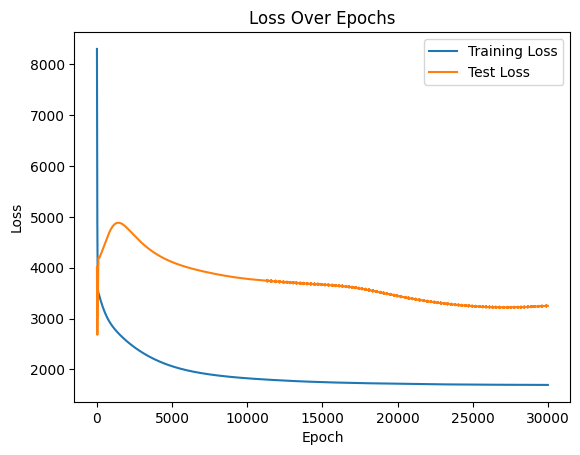

In [348]:
# Plotting the loss
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [349]:
with torch.no_grad():
    # Forward pass on test data
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, Y_test_tensor.view(-1, 1)).item()

    # Calculate loss percentage
    percentage_loss = (test_loss / Y_test_tensor.mean().item()) * 100

print(f'Test Loss: {test_loss:.4f}')
print(f'Percentage Loss: {percentage_loss:.2f}%')

Test Loss: 3251.5518
Percentage Loss: 7452.18%


In [350]:
# Assuming model, X_test_tensor, and y_test_tensor are already defined

# Get predicted values from the model
with torch.no_grad():
    y_pred = model(X_test_tensor)

# Convert tensors to numpy arrays
y_pred = y_pred.numpy()
y_test = Y_test_tensor.numpy()

# Calculate mean of the target variable
y_mean = np.mean(y_test)

# Calculate Total Sum of Squares (TSS)
tss = np.sum((y_test - y_mean) ** 2)

# Calculate Residual Sum of Squares (RSS)
rss = np.sum((y_test - y_pred.squeeze()) ** 2)

# Calculate R-squared (R^2)
r_squared = 1 - (rss / tss)

print("R-squared:", r_squared)

R-squared: -0.056153178215026855


In [351]:
import torch.optim as optim
class RidgeRegression(nn.Module):
    def __init__(self, input_dim, alpha):
        super(RidgeRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.alpha = alpha

    def forward(self, x):
        return self.linear(x)

# Assuming X_train_tensor and y_train_tensor are already defined

# Hyperparameters
input_dim = X_train_tensor.shape[1]
alpha = 0.001  # Ridge regularization parameter

# Instantiate the model
model = RidgeRegression(input_dim, alpha)

# Define loss function (mean squared error loss)
criterion = nn.MSELoss()

# Define optimizer (Stochastic Gradient Descent)
optimizer = optim.Adam(model.parameters(), lr=0.06)

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, Y_train_tensor)

    # Add ridge penalty to the loss
    l2_reg = torch.norm(model.linear.weight)
    loss += alpha * l2_reg

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Once training is done, you can use the model for prediction